In [3]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models

In [4]:
def resize_images_in_directory(root_folder, target_width, target_height):
    count_images_resize = 0
    target_size = (target_width, target_height)
    for folder_name, sub_folders, file_names in os.walk(root_folder):
        for filename in file_names:
            if filename.endswith(".jpg"):
                image_path = os.path.join(folder_name, filename)
                image = cv2.imread(image_path)
                resized_image = cv2.resize(image, target_size)
                cv2.imwrite(image_path, resized_image)
                count_images_resize += 1

    print(f"Resizing {count_images_resize} images to {target_width}x{target_height}")

In [5]:
def removeImagesCorrupted(root_folder):
    for folder_name, sub_folders, file_names in os.walk(root_folder):
        for filename in file_names:
            file_path = os.path.join(folder_name, filename)
            image_object = open(file_path, "rb")
            # Read the first 10 bytes to check for "JFIF" in the header
            header_data = image_object.read(10)
            is_jfif = tf.compat.as_bytes("JFIF") in header_data
            if not is_jfif:
                # Delete the corrupted image
                os.remove(file_path)
                print(f"Removed {file_path} (Corrupted image)")

In [6]:
target_width = 180
target_height = 180
images_directory = './img_cls'
resize_images_in_directory(images_directory, target_width, target_height)

Resizing 36781 images to 180x180


In [7]:
def create_image_datasets(data_directory, validation_split, seed):
    image_data, val_data = tf.keras.utils.image_dataset_from_directory(
        data_directory,
        image_size=(target_width, target_height),
        validation_split=validation_split,
        subset="both",
        seed=seed
    )
    
    return image_data, val_data

In [8]:
removeImagesCorrupted(images_directory)

In [9]:
validation_split = 0.2 # 80% for training, 20% for validation
seed = 16 # Random seed
train_ds, val_ds = create_image_datasets(images_directory, validation_split, seed)

Found 36781 files belonging to 80 classes.
Using 29425 files for training.
Using 7356 files for validation.


In [10]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])

train_ds_augmentation = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Combine the original training dataset and the augmented training dataset
combined_train_ds = train_ds.concatenate(train_ds_augmentation)

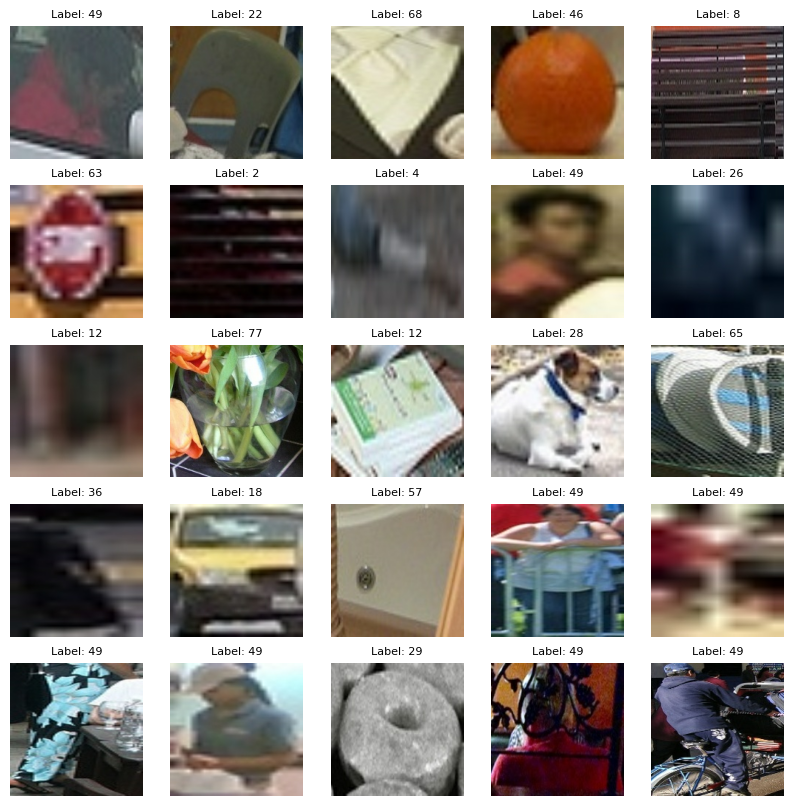

In [11]:
# Use train_ds because training using combined_train_ds take so much time.
# The accuracy when use combined_train_ds is ~0.30
#iterator = iter(combined_train_ds)
iterator = iter(train_ds)

# Number of images to display (row * column)
num_row_to_display = 5
num_columns_to_display = 5
num_images_to_display = num_row_to_display * num_columns_to_display
inch_for_each_image = 2
# Get and display the images
plt.figure(figsize=(num_row_to_display * inch_for_each_image, num_columns_to_display * inch_for_each_image)) # 10 inch x 10 inch
for idx_image in range(num_images_to_display):
    image, label = next(iterator)
    plt.subplot(num_row_to_display, num_columns_to_display, idx_image + 1)
    plt.imshow(image[0].numpy().astype("uint8"))  # Assuming images are in the first dimension
    plt.title(f"Label: {label[0].numpy()}", fontsize=8)
    plt.axis("off")

plt.show()

In [12]:
def make_model_old(input_shape, num_classes, learning_rate):
    model = models.Sequential()

    # --- Layer 1 ---
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Layer 2 ---
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Layer 3 ---
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Layer 4 ---
    model.add(layers.Flatten())

    # --- Layer 5 ---
    model.add(layers.Dense(units=128, activation='relu'))

    # --- Layer 6 ---
    model.add(layers.Dropout(rate=0.5))

    # --- Output Layer ---
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    # Compile the model
    #model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
def make_model(input_shape, num_classes, learning_rate):
    model = models.Sequential()

    # --- Layer 1 ---
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # --- Layer 2 ---
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.2))

    # --- Layer 3 ---
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.2))

    # --- Layer 4 ---
    model.add(layers.Flatten())
    
    # --- Layer 5 ---
    model.add(layers.Dropout(rate=0.5))

    # --- Layer 6 ---
    model.add(layers.Dense(units=128, activation='relu'))

    # --- Output Layer ---
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    # Compile the model
    #model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
# Define the input shape and number of classes
input_shape = (180, 180, 3)
num_classes = 80
learning_rate = 1e-5

In [15]:
# Create the model
model = make_model(input_shape, num_classes, learning_rate)

In [16]:
# Train the model
##history = model.fit(combined_train_ds, epochs=25, validation_data=val_ds)
history = model.fit(x=train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25


920/920 [==============================] - 307s 333ms/step - loss: 7.4966 - accuracy: 0.2428 - val_loss: 4.3770 - val_accuracy: 0.2915
Epoch 2/25
920/920 [==============================] - 318s 346ms/step - loss: 4.3887 - accuracy: 0.2931 - val_loss: 4.3716 - val_accuracy: 0.2915
Epoch 3/25
920/920 [==============================] - 371s 403ms/step - loss: 4.3744 - accuracy: 0.2966 - val_loss: 4.3664 - val_accuracy: 0.2915
Epoch 4/25
920/920 [==============================] - 351s 381ms/step - loss: 4.3686 - accuracy: 0.2991 - val_loss: 4.3612 - val_accuracy: 0.2915
Epoch 5/25
920/920 [==============================] - 365s 397ms/step - loss: 4.3603 - accuracy: 0.2997 - val_loss: 4.3560 - val_accuracy: 0.2915
Epoch 6/25
920/920 [==============================] - 318s 345ms/step - loss: 4.3539 - accuracy: 0.2997 - val_loss: 4.3508 - val_accuracy: 0.2915
Epoch 7/25
920/920 [==============================] - 291s 316ms/step - loss: 4.3478 - accuracy: 0.2999 - val_loss: 4.3455

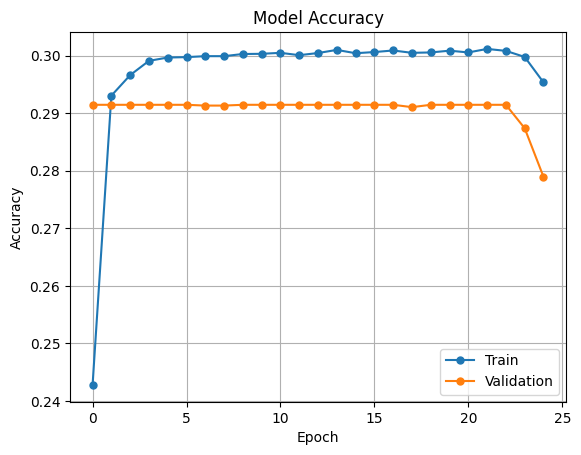

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label='Train', marker='o', markersize=5)
plt.plot(val_accuracy, label='Validation', marker='o', markersize=5)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 45, 45, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)      